<a href="https://colab.research.google.com/github/Chat809/Flat-View-Official/blob/main/FlatView.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Se ainda não fez: no Kaggle > "Create New API Token" => baixa kaggle.json
# No Colab: suba o arquivo (ícone de pasta à esquerda) ou use o seletor abaixo.

from google.colab import files
import os, json, zipfile, shutil

print("Selecione o seu kaggle.json")
uploaded = files.upload()  # selecione o kaggle.json

os.makedirs("/root/.kaggle", exist_ok=True)
with open("/root/.kaggle/kaggle.json", "wb") as f:
    key = list(uploaded.keys())[0]
    f.write(uploaded[key])

os.chmod("/root/.kaggle/kaggle.json", 0o600)

!pip -q install kaggle opencv-python scikit-learn matplotlib numpy
print("Kaggle API configurada.")


Selecione o seu kaggle.json


Saving kaggle.json to kaggle.json
Kaggle API configurada.


In [4]:
# Procure por termos: "burned area", "wildfire", "forest fire", "sentinel", "landsat"
query = "burned area"
!kaggle datasets list -s "{query}" -v | head -n 30

ref,title,size,lastUpdated,downloadCount,voteCount,usabilityRating
mohammadrahdanmofrad/global-fire-burned-area,Global Fire burned area,7117222,2023-11-04 13:46:41.073000,468,61,1.0
elikplim/forest-fires-data-set,Forest Fires Data Set,7268,2017-09-04 04:08:24.597000,19267,141,0.64705884
abdelghaniaaba/wildfire-prediction-dataset,Wildfire Prediction Dataset (Satellite Images),1551896015,2023-02-01 18:28:24.863000,13096,98,1.0
rtatman/188-million-us-wildfires,1.88 Million US Wildfires,176270559,2020-05-12 21:03:49.213000,39237,1376,0.8235294
imtkaggleteam/wildfires,WildFires 🌲🌴🔥,438365,2024-04-14 09:48:37.537000,1011,46,1.0
uttam94/forest-forest-dataset,Forest Fire Dataset,9060,2019-11-23 07:46:30.893000,840,14,0.64705884
vivekattri/california-wildfire-damage-2014-feb2025,California Wildfire Damage (2014-(feb)2025),3036,2025-02-05 10:05:12.500000,3082,47,0.9411765
nimapourmoradi/forest-fire-regression,Forest Fire Regression,7268,2024-02-15 15:21:15.467000,1245,82,0.9411765
willianoliveir

In [7]:
# >>> EDITE AQUI <<<: informe o slug do dataset do Kaggle (exemplo ilustrativo!)
DATASET_SLUG = "abdelghaniaaba/wildfire-prediction-dataset"

# Downloads
DOWNLOAD_DIR = "/content/data_raw"
EXTRACT_DIR  = "/content/data"
OUTPUT_DIR   = "/content/outputs"
for d in (DOWNLOAD_DIR, EXTRACT_DIR, OUTPUT_DIR):
    os.makedirs(d, exist_ok=True)

!kaggle datasets download -d {DATASET_SLUG} -p {DOWNLOAD_DIR} --force

# Extrair todos os .zip baixados
for fn in os.listdir(DOWNLOAD_DIR):
    if fn.lower().endswith(".zip"):
        with zipfile.ZipFile(os.path.join(DOWNLOAD_DIR, fn), 'r') as z:
            z.extractall(EXTRACT_DIR)

print("Arquivos extraídos em:", EXTRACT_DIR)
!find {EXTRACT_DIR} -maxdepth 3 -type f | head -n 30

Dataset URL: https://www.kaggle.com/datasets/abdelghaniaaba/wildfire-prediction-dataset
License(s): other
 99% 1.43G/1.45G [00:19<00:00, 182MB/s]
100% 1.45G/1.45G [00:19<00:00, 80.6MB/s]
Arquivos extraídos em: /content/data
/content/data/train/wildfire/-57.11902,51.47242.jpg
/content/data/train/wildfire/-57.8088,51.44634.jpg
/content/data/train/wildfire/-58.657,51.1945.jpg
/content/data/train/wildfire/-58.71402,51.32554.jpg
/content/data/train/wildfire/-58.7312,51.2023.jpg
/content/data/train/wildfire/-58.81589,51.78597.jpg
/content/data/train/wildfire/-58.88032,51.79047.jpg
/content/data/train/wildfire/-58.96863,50.90078.jpg
/content/data/train/wildfire/-59.0008,50.8606.jpg
/content/data/train/wildfire/-59.08647,51.09772.jpg
/content/data/train/wildfire/-59.12153,51.85762.jpg
/content/data/train/wildfire/-59.13463,51.86481.jpg
/content/data/train/wildfire/-59.1904,50.7664.jpg
/content/data/train/wildfire/-59.2239,51.9222.jpg
/content/data/train/wildfire/-59.23837,51.77878.jpg
/content

In [10]:
import glob

# Padrões de imagens
IMG_EXTS = ("*.jpg", "*.jpeg", "*.png", "*.tif", "*.tiff")

img_files = []
for ext in IMG_EXTS:
    img_files.extend(glob.glob(os.path.join(EXTRACT_DIR, "**", ext), recursive=True))

print("Total de imagens encontradas:", len(img_files))
img_files[:10]  # listar alguns arquivos encontrados


Total de imagens encontradas: 42850


['/content/data/train/wildfire/-71.52842,46.54047.jpg',
 '/content/data/train/wildfire/-68.68255,49.20893.jpg',
 '/content/data/train/wildfire/-72.87962,49.04137.jpg',
 '/content/data/train/wildfire/-73.23948,46.86931.jpg',
 '/content/data/train/wildfire/-74.91729,49.28058.jpg',
 '/content/data/train/wildfire/-69.52301,47.86661.jpg',
 '/content/data/train/wildfire/-74.4639,49.3127.jpg',
 '/content/data/train/wildfire/-74.8378,45.92566.jpg',
 '/content/data/train/wildfire/-75.46907,45.74221.jpg',
 '/content/data/train/wildfire/-62.63991,50.31655.jpg']

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tqdm.auto import tqdm
import os

os.makedirs(OUTPUT_DIR, exist_ok=True)

def load_rgb(path, max_side=768):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        return None
    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif img.shape[2] == 4:
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    scale = max_side / max(h, w)
    if scale < 1.0:
        img = cv2.resize(img, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)
    return img

def kmeans_segment_rgb(img_rgb, K=3, blur=True):
    data = img_rgb.copy()
    if blur:
        data = cv2.GaussianBlur(data, (3,3), 0)
    H, W = data.shape[:2]
    X = data.reshape(-1, 3).astype(np.float32)

    km = KMeans(n_clusters=K, random_state=42, n_init='auto')
    labels = km.fit_predict(X)
    centers = km.cluster_centers_

    seg = centers[labels].reshape(H, W, 3).astype(np.uint8)

    mean_brightness = centers.mean(axis=1)
    burned_cluster = np.argmin(mean_brightness)

    mask = (labels.reshape(H, W) == burned_cluster).astype(np.uint8) * 255
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3,3),np.uint8))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5,5),np.uint8))

    return seg, mask

def overlay_mask(img_rgb, mask, alpha=0.45):
    overlay = img_rgb.copy()
    red = np.zeros_like(img_rgb)
    red[...,0] = 255
    mask_bool = mask.astype(bool)
    overlay[mask_bool] = (overlay[mask_bool]*(1-alpha) + red[mask_bool]*alpha).astype(np.uint8)
    return overlay

MAX_IMAGES = 30  # aumente depois que validar
processed = 0

for path in tqdm(img_files[:MAX_IMAGES]):
    img = load_rgb(path, max_side=768)
    if img is None:
        continue
    seg, mask = kmeans_segment_rgb(img, K=3)
    over = overlay_mask(img, mask, alpha=0.45)

    base = os.path.splitext(os.path.basename(path))[0]
    cv2.imwrite(os.path.join(OUTPUT_DIR, f"{base}_seg_rgb.jpg"), cv2.cvtColor(seg, cv2.COLOR_RGB2BGR))
    cv2.imwrite(os.path.join(OUTPUT_DIR, f"{base}_mask_rgb.png"), mask)
    cv2.imwrite(os.path.join(OUTPUT_DIR, f"{base}_overlay_rgb.jpg"), cv2.cvtColor(over, cv2.COLOR_RGB2BGR))
    processed += 1

print(f"Imagens processadas (RGB): {processed}")
!ls -l {OUTPUT_DIR} | head -n 20


  0%|          | 0/30 [00:00<?, ?it/s]

Imagens processadas (RGB): 30
total 3504
-rw-r--r-- 1 root root  3910 Aug 25 16:05 -62.63991,50.31655_mask_rgb.png
-rw-r--r-- 1 root root 49179 Aug 25 16:05 -62.63991,50.31655_overlay_rgb.jpg
-rw-r--r-- 1 root root 30564 Aug 25 16:05 -62.63991,50.31655_seg_rgb.jpg
-rw-r--r-- 1 root root 10970 Aug 25 16:05 -67.2008,48.84772_mask_rgb.png
-rw-r--r-- 1 root root 86471 Aug 25 16:05 -67.2008,48.84772_overlay_rgb.jpg
-rw-r--r-- 1 root root 70170 Aug 25 16:05 -67.2008,48.84772_seg_rgb.jpg
-rw-r--r-- 1 root root  5269 Aug 25 16:05 -67.39177,49.44544_mask_rgb.png
-rw-r--r-- 1 root root 69058 Aug 25 16:05 -67.39177,49.44544_overlay_rgb.jpg
-rw-r--r-- 1 root root 59043 Aug 25 16:05 -67.39177,49.44544_seg_rgb.jpg
-rw-r--r-- 1 root root 10670 Aug 25 16:05 -68.01359,49.85672_mask_rgb.png
-rw-r--r-- 1 root root 68867 Aug 25 16:05 -68.01359,49.85672_overlay_rgb.jpg
-rw-r--r-- 1 root root 54454 Aug 25 16:05 -68.01359,49.85672_seg_rgb.jpg
-rw-r--r-- 1 root root  1778 Aug 25 16:05 -68.68255,49.20893_mask_

In [13]:
import cv2, numpy as np, os
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from google.colab import files

def load_rgb_for_classify(path, max_side=1024):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise ValueError(f"Não consegui abrir: {path}")
    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    if img.shape[2] == 4:
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    sc = max_side / max(h, w)
    if sc < 1.0:
        img = cv2.resize(img, (int(w*sc), int(h*sc)), interpolation=cv2.INTER_AREA)
    return img

def kmeans_rgb_mask_burned(img_rgb, K=4):
    H, W = img_rgb.shape[:2]
    blur = cv2.GaussianBlur(img_rgb, (3,3), 0)
    X = blur.reshape(-1, 3).astype(np.float32)
    km = KMeans(n_clusters=K, random_state=42, n_init='auto')
    labels = km.fit_predict(X)
    centers = km.cluster_centers_.astype(np.float32)
    mean_V = centers.mean(axis=1)
    burned_idx = np.argmin(mean_V)
    mask = (labels.reshape(H, W) == burned_idx).astype(np.uint8) * 255
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3,3),np.uint8))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5,5),np.uint8))
    return mask, labels.reshape(H, W), centers

def overlay(img_rgb, mask, alpha=0.45):
    over = img_rgb.copy()
    red = np.zeros_like(img_rgb); red[...,0] = 255
    m = mask.astype(bool)
    over[m] = (over[m]*(1-alpha) + red[m]*alpha).astype(np.uint8)
    return over

def classify_from_mask(mask, img_rgb, burned_min_pct=8, maybe_min_pct=1):
    pct = (mask>0).mean()*100
    status = "Sem indício relevante de queimada"
    if pct >= burned_min_pct:
        status = f"Provável queimada (área estimada ≥ {burned_min_pct}%)"
    elif pct >= maybe_min_pct:
        status = f"Possível queimada localizada ({maybe_min_pct}–{burned_min_pct}%)"
    return status, round(pct,2)

def show_results(img_rgb, mask, centers, status, pct):
    over = overlay(img_rgb, mask, alpha=0.45)
    plt.figure(figsize=(14,5))
    plt.subplot(1,3,1); plt.imshow(img_rgb); plt.title("Imagem"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(over); plt.title("Overlay (área suspeita)"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(mask, cmap='gray'); plt.title(f"Máscara (~{pct}%)"); plt.axis("off")
    plt.suptitle(status)
    plt.show()


Envie uma imagem (JPG/PNG) para classificar:


Saving brazilfires_amo_2019223_lrg.jpg to brazilfires_amo_2019223_lrg.jpg


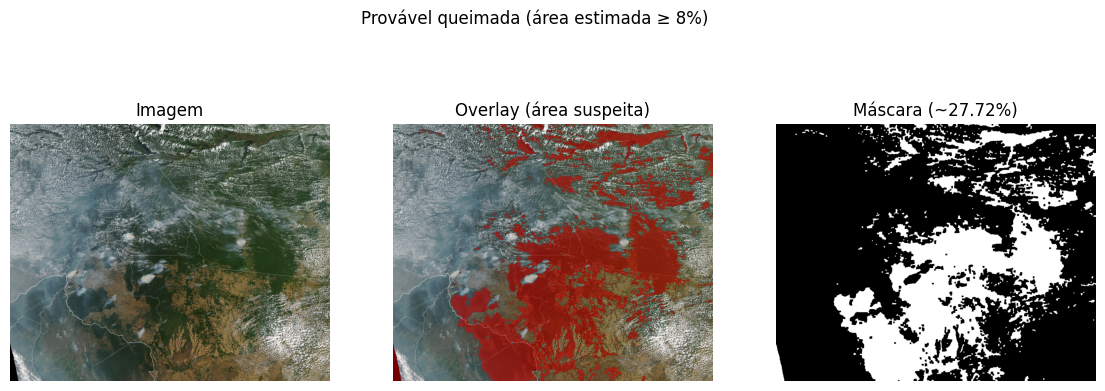

Resultado: Provável queimada (área estimada ≥ 8%) | Cobertura suspeita: 27.72 %


In [14]:
print("Envie uma imagem (JPG/PNG) para classificar:")
up = files.upload()  # selecione sua imagem
path = list(up.keys())[0]

img = load_rgb_for_classify(path)
mask, _, centers = kmeans_rgb_mask_burned(img, K=4)
status, pct = classify_from_mask(mask, img, burned_min_pct=8, maybe_min_pct=1)
show_results(img, mask, centers, status, pct)

print("Resultado:", status, "| Cobertura suspeita:", pct, "%")